<a href="https://colab.research.google.com/github/Vaycold/Python_DL/blob/main/Image_Transformation/AutoEncoder%EB%A5%BC%20%ED%99%9C%EC%9A%A9%ED%95%9C%20%EC%9D%B4%EB%AF%B8%EC%A7%80%20%EB%B3%B5%EC%9B%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Goal
    - noisy가 있는 fashion MNIST 이미지 원래대로 복구
    - 흑백이미지와 컬러 이미지의 차이
    - 이미지에 noisy 추가
    - 이미지에 대한 autoencoder식 접근방법
    

In [1]:
# Load the package
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from IPython.display import Image

warnings.filterwarnings('ignore')
seed = 34

In [2]:
# Load the dataset
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels) , (test_images, test_labels) = fashion_mnist.load_data()
print(train_images.shape)
print(test_labels.shape)

4423680/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000,)


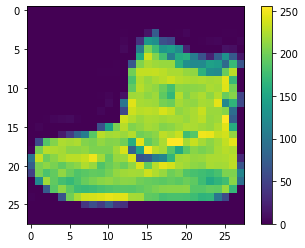

In [3]:
# 이미지 출력

plt.imshow(train_images[0])
plt.colorbar()
plt.show()

In [4]:
# 0이 아닌 값들을 확인

list(filter(lambda x : x != 0, train_images[0].reshape(-1)))[:10]


[1, 13, 73, 1, 4, 1, 1, 3, 36, 136]

## Pre-processing
    

In [5]:
# 0-1 normailzie scaling
train_images = train_images / 255
test_images = test_images / 255

In [6]:
print(min(train_images.reshape(-1)), max(train_images.reshape(-1)))

0.0 1.0


In [7]:
# gray-scale shape -> color map shape

from skimage import color
print(f'train_images shape : {train_images[0].shape}')
print(f"gray2rgb's shape : {color.gray2rgb(train_images[0]).shape}")

train_images shape : (28, 28)
gray2rgb's shape : (28, 28, 3)


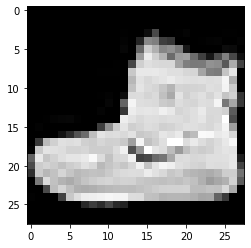

In [8]:
plt.imshow(color.gray2rgb(train_images[0]))
plt.show()

In [9]:
train_images = np.array([color.gray2rgb(img) for img in train_images])
test_images = np.array([color.gray2rgb(img) for img in test_images])
print(train_images.shape, test_images.shape)

(60000, 28, 28, 3) (10000, 28, 28, 3)


## Visualization
    

In [10]:
# Using 5 train_images

train_images[:5].shape

(5, 28, 28, 3)

In [11]:
# image shape change : (5,28,28,3 ) -> (28, 28*5, 3)
np.hstack(train_images[:5]).shape

(28, 140, 3)

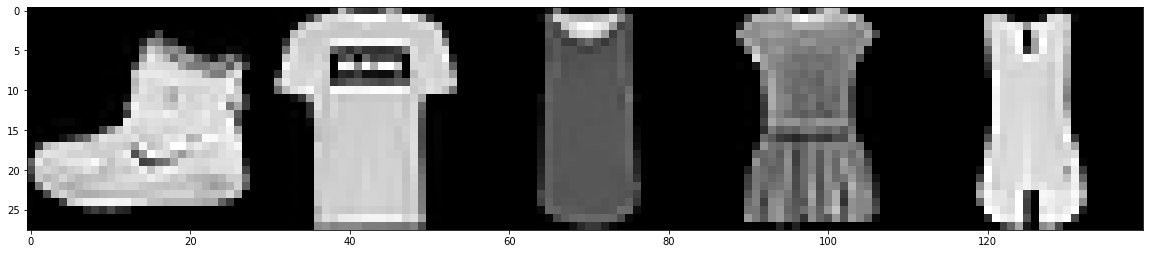

In [12]:
plt.figure(figsize=(20,5))
plt.imshow(np.hstack(train_images[:5]))
plt.show()

In [13]:
# Another Method (recommend)
print(train_images[:5].shape)
print(train_images[:5].transpose( (1, 0, 2, 3)  ).shape) # (orignal : 0 , 1, 2, 3) -> (changed : 1, 0, 2, 3)
print(train_images[:5].transpose( (1, 0, 2, 3)  ).reshape((28,-1,3)).shape)

(5, 28, 28, 3)
(28, 5, 28, 3)
(28, 140, 3)


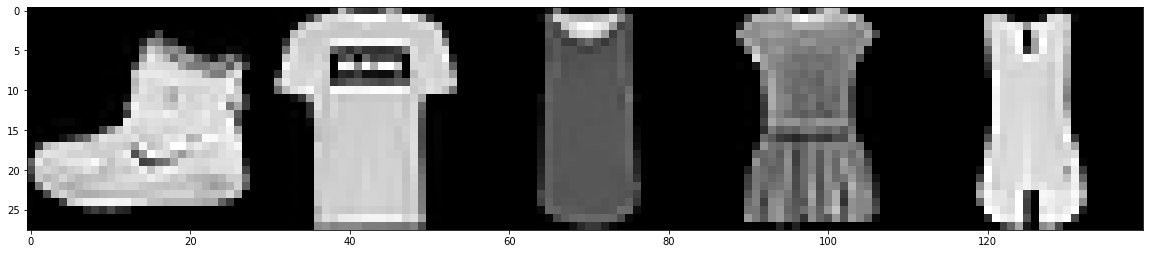

In [14]:
plt.figure(figsize=(20,5))
plt.imshow(train_images[:5].transpose( (1, 0, 2, 3)  ).reshape((28,-1,3)))
plt.show()

## Add noisy
    

In [15]:
np.random.random()

0.30615662813548605

In [16]:
# (28,28,3)의 noise 생성
np.random.random((28,28,3)).shape

(28, 28, 3)

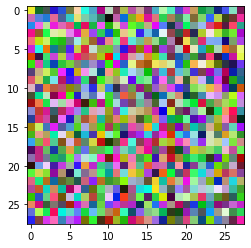

In [17]:
plt.imshow(np.random.random((28,28,3)))
plt.show()

In [18]:
# Gaussian noise
np.random.normal(0,0.1,3)

array([ 0.26903345, -0.12747673,  0.06076525])

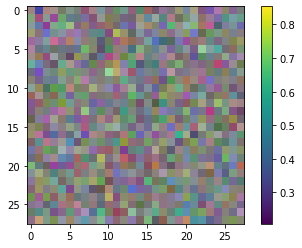

In [19]:
noise = np.random.normal(0.5, 0.1, (28,28,3))
plt.imshow(noise)
plt.colorbar()
plt.show()

In [20]:
# Adding 'noise' to #.5 images 
print(train_images[5].shape)
print(noise.shape)
print((train_images[5] + noise).shape)

(28, 28, 3)
(28, 28, 3)
(28, 28, 3)


In [21]:
noise_image = train_images[5] + noise
print(min(noise_image.reshape(-1)), max(noise_image.reshape(-1)))
noise_image[noise_image > 1 ] = 1.0
print(max(noise_image.reshape(-1)))

0.23013715180818234 1.7049868859747392
1.0


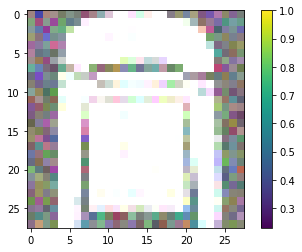

In [22]:
plt.imshow(noise_image)
plt.colorbar()
plt.show()

In [23]:
# Adding 'noise' to Entire dataset
train_images.shape

(60000, 28, 28, 3)

In [24]:
train_noisy_images = train_images + np.random.normal(0.5, 0.2, train_images.shape)
train_noisy_images[train_noisy_images > 1] = 1
test_noisy_images = test_images + np.random.normal(0.5, 0.2, test_images.shape)
test_noisy_images[test_noisy_images > 1] = 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


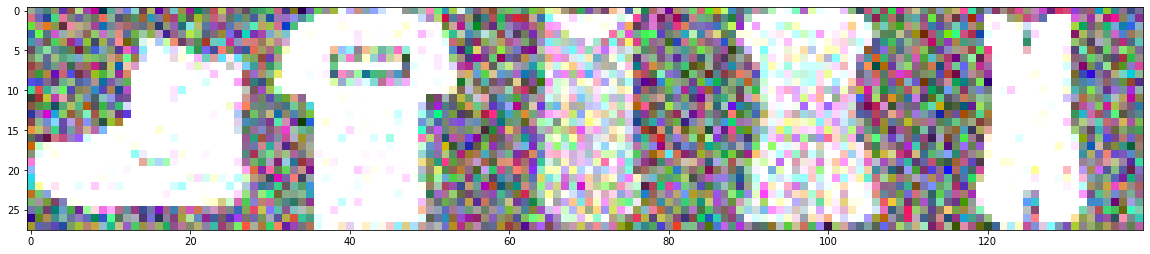

In [25]:
# Checking the noise_images
plt.figure(figsize=(20,5))
plt.imshow(train_noisy_images[:5].transpose( (1, 0, 2, 3)  ).reshape((28,-1,3)))
plt.show()

## Modeling

``` 
 -  image denoising model
 -  Autoencoder
```

In [26]:
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model
'''
autoencoder : 28x28 짜리가 점점 작아지다가 커지는 모래시계형 구조
'''
inputs = Input(shape=(28, 28, 3))
x = Conv2D(32, kernel_size = 3, strides= 2, activation = 'relu', padding='same')(inputs)
x = Conv2D(64, kernel_size = 3, strides= 2, activation = 'relu', padding='same')(x)
x = Flatten()(x) # 여기까지가 작아지는 부분
latent = Dense(10)(x) # 1차원 벡터로 바꿈

x = Dense(7*7*64)(latent)
x = Reshape((7,7,64))(x) # CNN에서 뱉어낸 형태로 바꿔줌
x = Conv2DTranspose(64, 3, 2, activation = 'relu', padding='same')(x)
x = Conv2DTranspose(32, 3, 2, activation = 'relu', padding='same')(x)
x = Conv2DTranspose(3, 3, activation = 'sigmoid', padding='same')(x)

model = Model(inputs, x)

In [27]:
# model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                31370     
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              34496     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0     

In [29]:
# Model evaluation
model.compile(
    loss = 'mse',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [30]:
hist = model.fit(train_noisy_images, train_images,
                 validation_data = (test_noisy_images, test_images),
                 epochs = 5,
                 verbose = 2) #입력값 input (28,28,3 ) output 값도 (28,28)이 아니라 (28,28,3)이어야 함.

Epoch 1/5
1875/1875 - 102s - loss: 0.0275 - accuracy: 0.3048 - val_loss: 0.0173 - val_accuracy: 0.2934
Epoch 2/5
1875/1875 - 103s - loss: 0.0164 - accuracy: 0.2816 - val_loss: 0.0157 - val_accuracy: 0.2801
Epoch 3/5
1875/1875 - 99s - loss: 0.0151 - accuracy: 0.2882 - val_loss: 0.0147 - val_accuracy: 0.3058
Epoch 4/5
1875/1875 - 99s - loss: 0.0144 - accuracy: 0.3269 - val_loss: 0.0143 - val_accuracy: 0.3407
Epoch 5/5
1875/1875 - 99s - loss: 0.0139 - accuracy: 0.3675 - val_loss: 0.0141 - val_accuracy: 0.3667


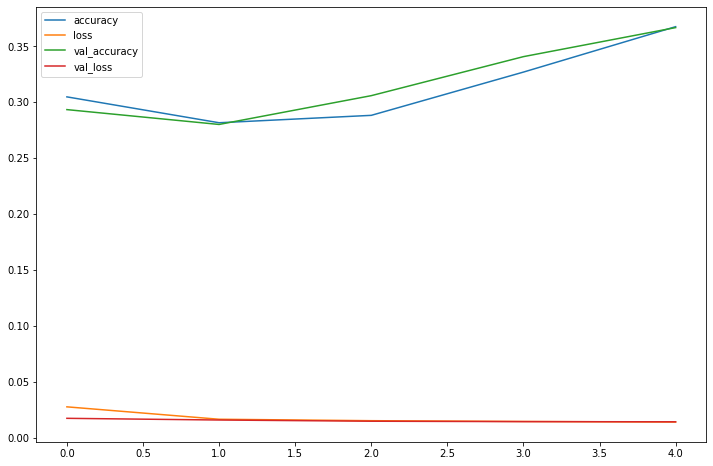

In [34]:
# history
plt.figure(figsize=(12,8))
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

## Result

```
모든 픽셀에 대해 noise가 있었기 때문에 accuracy를 100으로 맞추기는 힘듦
다양한 지표로 성능을 확인해볼 필요가 있음.
그래서 loss가 줄고 있는 지에 대해서만 확인하고 넘어가야 했었음.

    

In [37]:
test_noisy_images[5].shape # (1,28,28,3) 으로 넣어야 함.
test_noisy_images[5].reshape((1,28,28,-1)).shape # 방법 1
test_noisy_images[5:6].shape # 방법2

(1, 28, 28, 3)

In [38]:
model.predict(test_noisy_images[5:6]).shape

(1, 28, 28, 3)

In [39]:
res = model.predict(test_noisy_images[5:6])

(1, 28, 28, 3)

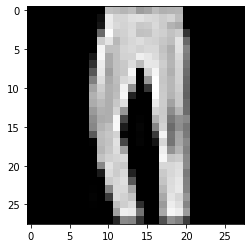

In [40]:
# 모델에 나온 출력값과 test_noisy_images[5], test_images[5]를 width 방향으로 결합(28, 28*3, 3)의 이미지 만들어 출력
plt.imshow(test_images[5])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


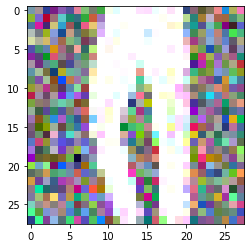

In [41]:
plt.imshow(test_noisy_images[5])
plt.show()

TypeError: ignored

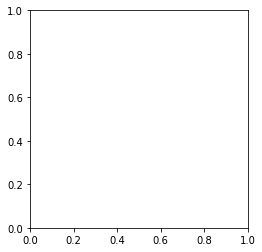

In [42]:
plt.imshow(res)
plt.show() # 이건 배치정보기 때문에 이렇게 불러올 수 없음

In [43]:
test_noisy_images[5].shape

(28, 28, 3)

In [44]:
res.shape

(1, 28, 28, 3)

In [51]:
res[0].shape

(28, 28, 3)

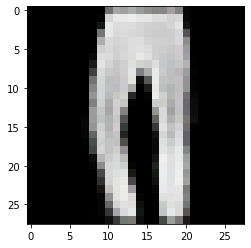

In [46]:
plt.imshow(res.reshape((28,28,3)))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(28, 84, 3)


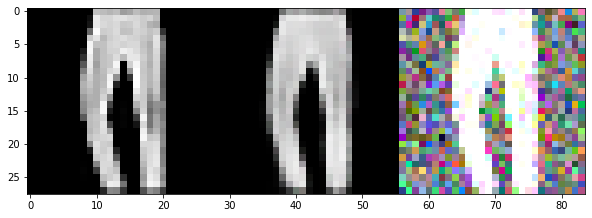

In [57]:
# 합쳐보자
img = np.concatenate(
    [ test_images[5], res[0], test_noisy_images[5] ], axis=1
)
print(img.shape)
plt.figure(figsize=(10,5))
plt.imshow(img)
plt.show()

In [63]:
# 5장의 test_noisy_images를 모델에 넣은 뒤 결과를 위 방식으로 비교
five = model.predict(test_noisy_images[:5])
np.concatenate(
    [ test_images[:5], five, test_noisy_images[:5] ], axis = 2 # axis =2 
).shape

(5, 28, 84, 3)

In [71]:
result = np.concatenate(
    [ test_images[:5], five, test_noisy_images[:5] ]
    , axis = 2).transpose((1,0,2,3)).reshape((28,-1,3)) # axis =2 
result.shape

(28, 420, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


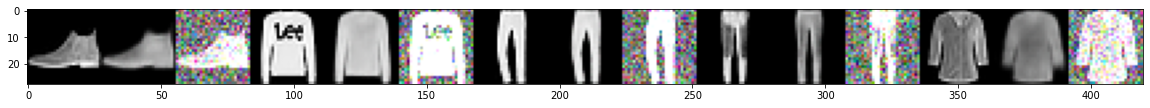

In [73]:
plt.figure(figsize =(20,6))
plt.imshow(result)

## Model save

    

In [74]:
# model save
model.save('./lecture002.h5')

In [75]:
# model load
new_model =tf.keras.models.load_model('./lecture002.h5')

In [76]:
# evaluation with new model
loss, accuracy = model.evaluate(test_noisy_images, test_images, verbose = 1)
print( loss, accuracy)
loss, accuracy = new_model.evaluate(test_noisy_images, test_images, verbose = 1)
print( loss, accuracy)

313/313 [==============================] - 7s 22ms/step - loss: 0.0141 - accuracy: 0.3667
0.014139615930616856 0.3667071461677551
313/313 [==============================] - 7s 22ms/step - loss: 0.0141 - accuracy: 0.3667
0.014139615930616856 0.3667071461677551


In [77]:
# save model in local pc

from google.colab import files
files.download('./lecture002.h5'.)


SyntaxError: ignored